## 1. 前置設定
### 1.1 關閉 GPU
在使用 GPU 訓練模型時，硬體平行加速可能會有一些隨機性的產生。因此若要重現模型實驗結果必須關閉 GPU。

In [1]:
# disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
# 拿取 GPU 資源
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)
print(len(physical_devices), 'devices detect')

0 devices detect


### 1.2 亂數設定
為了實現模型再現性，必須鎖定亂數使得模型每次訓練結果都一樣。

In [3]:
# 設定亂數種子數值
seed_value= 4
# 1. 設定 Python 環境變數亂數種子
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. 設定 Python 內建亂數生成器亂數種子
import random
random.seed(seed_value)
# 3. 設定 Numpy 亂數種子
import numpy as np
np.random.seed(seed_value)
# 4. 設定 TensorFlow 亂數種子
import tensorflow as tf
tf.random.set_seed(seed_value)

## 2. 讀取資料集

In [ ]:
import os

os.makedirs('datasets', exist_ok=True) # 建立資料夾
# 下載資料集
!wget -c https://raw.githubusercontent.com/1010code/tensorflow-reproducibility/main/datasets/dog_cat.tar -P datasets
!tar xvf datasets/dog_cat.tar -C datasets

### 2.1 Data Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = 150

train_datagen = ImageDataGenerator( 
                                    rescale=1./255,
                                    rotation_range=10,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode='reflect', 
                                    zoom_range=0.01,
                                    validation_split=0.1
                                 )
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_directory(
                                                    './datasets/dog_cat/train',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    seed=42,                                                
                                                    class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(
                                                   './datasets/dog_cat/train',
                                                   target_size=(img_size, img_size),
                                                   batch_size=batch_size,
                                                   subset="validation",
                                                   seed=42,
                                                   class_mode='categorical')

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
                                                   './datasets/dog_cat/test',
                                                   target_size=(img_size, img_size),
                                                   batch_size=1,
                                                   class_mode='categorical')

Found 1000 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [9]:
classes=list(train_generator.class_indices) # 類別名稱
num_classes = len(train_generator.class_indices) # 類別數量

### 2.2 Visualize the dataset

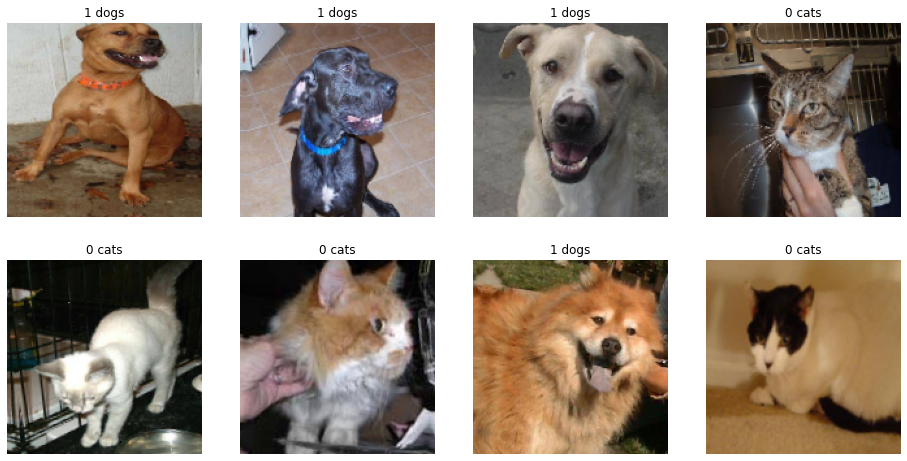

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for i in range(8):
    img , label = train_generator.next()
    label=label[i].argmax()
    plt.subplot(2, 4, i+1)
    plt.title(f'{label} {classes[label]}')
    plt.imshow(img[i])
    plt.axis('off')

## 3. 搭建 CNN 模型

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [12]:
tf.keras.backend.clear_session() # 清空網路暫存
img_input = layers.Input(shape=(img_size, img_size, 3))

x = layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
output = layers.Dense(num_classes, activation='softmax')(x)

simple_cnn_no_attention = Model(img_input, output)

In [13]:
simple_cnn_no_attention.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [14]:
simple_cnn_no_attention.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)      

### 訓練模型
訓練集共有 1800 筆影像，batch_size 設定 32。訓練 10 代，每次訓練結果使用 200 張影像的驗證集進行評估。

In [15]:
history = simple_cnn_no_attention.fit(train_generator, validation_data=valid_generator, epochs=10)

Epoch 1/10
57/57 [==============================] - 18s 318ms/step - loss: 1.1340 - accuracy: 0.5272 - val_loss: 0.6758 - val_accuracy: 0.5500
Epoch 2/10
57/57 [==============================] - 17s 298ms/step - loss: 0.6728 - accuracy: 0.5789 - val_loss: 0.6742 - val_accuracy: 0.5900
Epoch 3/10
57/57 [==============================] - 17s 301ms/step - loss: 0.6412 - accuracy: 0.6467 - val_loss: 0.6504 - val_accuracy: 0.6450
Epoch 4/10
57/57 [==============================] - 17s 297ms/step - loss: 0.6034 - accuracy: 0.6744 - val_loss: 0.6269 - val_accuracy: 0.6500
Epoch 5/10
57/57 [==============================] - 17s 298ms/step - loss: 0.6356 - accuracy: 0.6350 - val_loss: 0.6423 - val_accuracy: 0.6250
Epoch 6/10
57/57 [==============================] - 17s 291ms/step - loss: 0.5924 - accuracy: 0.6917 - val_loss: 0.6336 - val_accuracy: 0.6900
Epoch 7/10
57/57 [==============================] - 17s 304ms/step - loss: 0.5729 - accuracy: 0.6972 - val_loss: 0.5901 - val_accuracy: 0.7000

In [16]:
print(f"Test accuracy: {simple_cnn_no_attention.evaluate(test_generator)[1]}")

1000/1000 [==============================] - 5s 5ms/step - loss: 0.5877 - accuracy: 0.7060
Test accuracy: 0.7059999704360962
